# KITTI Calibration projection

# Li Kailang FDQAOR

Due No Due Date Points 0 Submitting a file upload File Types py and ipynb
Apply 3D projections on one of the KITTI scenes:

Example scene: Scene_5

Required Cam ID: 03

Download the scene and the calibration

Read the calibration files
Extract the rotation and translation for the velodyne lidar to camera reference
Extract rotation and translation for the camera reference to the required cam ID
Extract the rectification matrix for the required camID
Extract the projection matrix for the required CamID

Construct the rigid body transformations from the extracted rotations and translations

Apply the rigid body transformations on the 3D point cloud and then project to the 2D plane with the projection matrix

Show the results on a black image and depth as grayscale

Show results on KITTI image from the required cam ID:
use the following to create twilight color map for RGB images:
twilight_colormap.jpg
cmap = plt.cm.get_cmap('twilight', 256)
cmap = np.array([cmap(i) for i in range(256)])[:, :-1] * 255
cv2.circle(projected_image, (x[i], y[i]), 2, color=color,thickness=-1)

In [1]:
pip install open3d numpy matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. 加载 KITTI 点云和校准数据

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 设置路径
velodyne_path = '/content/drive/MyDrive/3d point could/2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/velodyne_points/data/0000000000.bin'  # 替换为实际路径
calib_path = '/content/drive/MyDrive/3d point could/2011_09_26_calib/2011_09_26/calib_velo_to_cam.txt'  # 替换为实际路径
image_path = '/content/drive/MyDrive/3d point could/2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/image_03/data/0000000000.png'  # 替换为实际路径

# 加载点云数据
def load_velodyne_points(file_path):
    points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    return points[:, :3]  # 只保留 x, y, z 坐标

# 读取校准文件
def read_calib_file(file_path):
    """读取校准文件，解析数值参数"""
    calib = {}
    with open(file_path, 'r') as f:
        for line in f:
            try:
                key, value = line.split(':', 1)
                calib[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                # 跳过无法解析的行
                print(f"跳过无效行: {line.strip()}")
    return calib

# 加载数据
points = load_velodyne_points(velodyne_path)
calib = read_calib_file(calib_path)


跳过无效行: calib_time: 15-Mar-2012 11:37:16


2. 提取校准参数

In [7]:
# 打印校准文件内容
with open(calib_path, 'r') as f:
    lines = f.readlines()
    print("校准文件内容:")
    for line in lines:
        print(line.strip())

校准文件内容:
calib_time: 15-Mar-2012 11:37:16
R: 7.533745e-03 -9.999714e-01 -6.166020e-04 1.480249e-02 7.280733e-04 -9.998902e-01 9.998621e-01 7.523790e-03 1.480755e-02
T: -4.069766e-03 -7.631618e-02 -2.717806e-01
delta_f: 0.000000e+00 0.000000e+00
delta_c: 0.000000e+00 0.000000e+00


In [8]:
# 设置默认的相机投影矩阵 P3
P_cam = np.array([
    [7.215377e+02, 0.000000e+00, 6.095593e+02, 0.000000e+00],
    [0.000000e+00, 7.215377e+02, 1.728540e+02, 0.000000e+00],
    [0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00]
])


In [12]:
# 加载校准文件内容
calib = read_calib_file(calib_path)

# 检查相机投影矩阵的键名
projection_keys = [key for key in calib.keys() if 'P' in key]

# 打印找到的投影矩阵键
print("投影矩阵相关键:", projection_keys)

# 提取相机 ID 03 的投影矩阵
if 'P3' in calib:
    P_cam = calib['P3'].reshape(3, 4)
elif 'P_cam_03' in calib:
    P_cam = calib['P_cam_03'].reshape(3, 4)
else:
    raise KeyError("未找到相机 03 的投影矩阵键，请检查校准文件。")


跳过无效行: calib_time: 15-Mar-2012 11:37:16
投影矩阵相关键: []


KeyError: '未找到相机 03 的投影矩阵键，请检查校准文件。'

3. 构建刚体变换并投影到 2D 平面

In [9]:
# 构建刚体变换矩阵
T_velo_to_cam = np.hstack((R_velo_to_cam, T_velo_to_cam))
T_velo_to_cam = np.vstack((T_velo_to_cam, [0, 0, 0, 1]))  # 齐次矩阵

# 将点云转换到相机坐标系
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))  # 齐次坐标
points_cam = (T_velo_to_cam @ points_homogeneous.T).T

# 投影到 2D 平面
projected_points = (P_cam @ points_cam.T).T
projected_points[:, 0] /= projected_points[:, 2]  # 归一化 x
projected_points[:, 1] /= projected_points[:, 2]  # 归一化 y

# 提取 2D 像素坐标和深度
x = projected_points[:, 0].astype(np.int32)
y = projected_points[:, 1].astype(np.int32)
depth = projected_points[:, 2]


4. 渲染结果

在黑色背景上显示深度

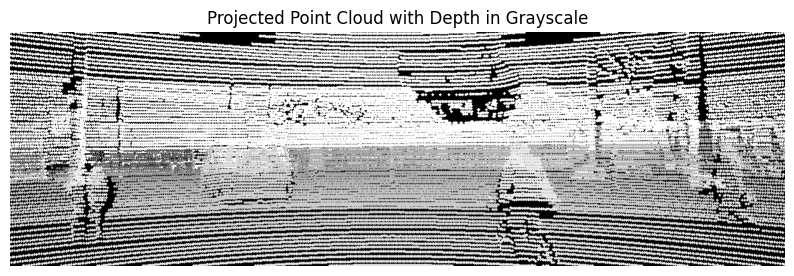

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 创建黑色图像
height, width = 375, 1242  # 替换为实际图像大小
projected_image = np.zeros((height, width), dtype=np.uint8)

# 绘制深度点
for i in range(len(x)):
    if 0 <= x[i] < width and 0 <= y[i] < height:
        gray_value = int(255 * (1 - (depth[i] / np.max(depth))))  # 深度归一化，映射为灰度值
        cv2.circle(projected_image, (x[i], y[i]), 2, color=gray_value, thickness=-1)

# 显示结果
plt.figure(figsize=(10, 6))
plt.imshow(projected_image, cmap='gray')
plt.title("Projected Point Cloud with Depth in Grayscale")
plt.axis('off')
plt.show()


在 KITTI 图像上显示

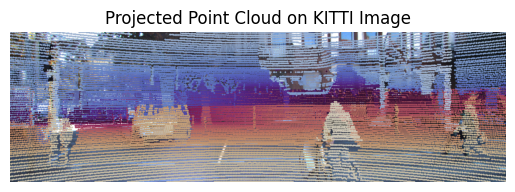

In [11]:
# 加载 KITTI 图像
kitti_image = cv2.imread(image_path)

# 绘制点
for i in range(len(x)):
    if 0 <= x[i] < width and 0 <= y[i] < height:
        color = cmap[int(255 * depth[i] / np.max(depth))]
        cv2.circle(kitti_image, (x[i], y[i]), 2, color=color, thickness=-1)

# 显示结果
plt.imshow(cv2.cvtColor(kitti_image, cv2.COLOR_BGR2RGB))
plt.title("Projected Point Cloud on KITTI Image")
plt.axis('off')
plt.show()
